<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARMIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Libraries and Indicator Function

!pip install -q bta-lib
!pip install -q ta

import btalib
import numpy as np
import pandas as pd
from ta.trend import PSARIndicator
from ta.momentum import WilliamsRIndicator
from ta.trend import AroonIndicator
from ta.volume import VolumePriceTrendIndicator
from ta.trend import CCIIndicator
from ta.momentum import ROCIndicator
from ta.trend import ADXIndicator
import yfinance as yf
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")


def create_indicators(data):
  data["RSI"] = btalib.rsi(data["Close"], period=14).df
  data["SMA5"] = btalib.sma(data['Close'], period=5).df
  data["SMA9"] = btalib.sma(data['Close'], period=9).df
  data["SMA10"] = btalib.sma(data['Close'], period=10).df
  data["SMA14"] = btalib.sma(data['Close'], period=14).df
  data["SMA20"] = btalib.sma(data['Close'], period=20).df
  data["SMA21"] = btalib.sma(data['Close'], period=21).df
  data["SMA50"] = btalib.sma(data['Close'], period=50).df
  data["SMA200"] = btalib.sma(data['Close'], period=200).df
  data["EMA5"] = btalib.ema(data['Close'], period=5).df
  data["EMA14"] = btalib.ema(data['Close'], period=14).df
  data["EMA21"] = btalib.ema(data['Close'], period=21).df
  data["EMA50"] = btalib.ema(data['Close'], period=50).df
  data["STOCH-K"] = btalib.stoch(data['High'], data['Low'], data['Close']).df["k"]
  data["STOCH-D"] = btalib.stoch(data['High'], data['Low'], data['Close']).df["d"]
  data["MACD"] = btalib.macd(data['Close']).df["macd"]
  data["SIGNAL"] = btalib.macd(data['Close']).df["signal"]
  data["HISTOGRAM"] = btalib.macd(data['Close']).df["histogram"]
  data["BB-UPPER"] = btalib.bbands(data['Close']).df['top']
  data["BB-MID"] = btalib.bbands(data['Close']).df['mid']
  data["BB-LOWER"] = btalib.bbands(data['Close']).df['bot']
  data["STDEV"] = data["Close"].rolling(window=10).std()
  data["PSAR"] = PSARIndicator(data["High"], data["Low"], data["Close"]).psar()
  data["WILLIAMS"] = WilliamsRIndicator(data["High"], data["Low"], data["Close"]).williams_r()
  data["AROON"] = AroonIndicator(close=data["Close"], window=25).aroon_indicator()
  data["OBV"] = VolumePriceTrendIndicator(close=data['Close'], volume=data['Volume']).volume_price_trend()
  data['CCI'] = CCIIndicator(close=data['Close'], low=data["Low"], high=data["High"], window=14).cci()
  data['ROC'] = ROCIndicator(close=data['Close'], window=5).roc()
  data['BULL'] = data['High'] - (data['High'].rolling(13).max() + data['Low'].rolling(13).min()) / 2
  data['BEAR'] = data['Low'] - (data['High'].rolling(13).max() + data['Low'].rolling(13).min()) / 2
  adx_indicator = ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
  data['ADX'] = adx_indicator.adx()
  data['+DI'] = adx_indicator.adx_pos()
  data['-DI'] = adx_indicator.adx_neg()

  data = data.dropna()
  data = data.reset_index()
  return data

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


In [ ]:
#@title Download the Model

import gdown

gdown.download("https://drive.google.com/u/1/uc?id=1qWKIj9rzRzyW3GQFw9xISs4eXmjyIDng&export=download", "/content/", quiet=False)
gdown.download("https://drive.google.com/u/0/uc?id=117pezAA6jRLCwIsdpEhZgEa9tEanlC0O&export=download", "/content/", quiet=False)

data = pd.read_csv("data.csv")
model = tf.keras.models.load_model("best_model.h5")

In [2]:
#@title Stock List
sheet_id = "1RSqOXkFTAO7g4H9LEY3d3IX6H6bJaYk1"
sheet_name = "Sheet_1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
result_df = pd.read_csv(url)

# sheet_id = "1AA9MfqOtAAgO97__aomD79DciyT-PkRQ"
# sheet_name = "Sheet_1"
# url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
# result_df = pd.read_csv(url)

nasdaq100 = ['AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN',
             'NVDA', 'TSLA', 'META', 'AVGO', 'ASML',
             'PEP', 'COST', 'ADBE', 'AZN', 'CSCO',
             'NFLX', 'AMD', 'CMCSA', 'TMUS', 'TXN',
             'QCOM', 'HON', 'INTU', 'INTC', 'SNY',
             'VZ', 'AMGN', 'SBUX', 'ISRG', 'AMAT',
             'BKNG', 'ADI', 'MDLZ', 'PDD', 'GILD',
             'ADP', 'VRTX', 'ABNB', 'LRCX', 'PYPL',
             'REGN', 'EQIX', 'MU', 'CSX', 'SNPS',
             'CME', 'CDNS', 'KLAC', 'NTES']

In [13]:
data = pd.DataFrame()

for stock in ["TSLA"]:
  stock_df = yf.download(stock, start="2020-01-01", end="2023-01-01", progress=False)
  stock_df = create_indicators(stock_df)
  stock_df["signal"] = 0

  for index, row in stock_df.iterrows():
    if index > 0 and index < stock_df.shape[0]-1 and stock_df["Close"].iloc[index+1] > ((2.5*stock_df["Close"].iloc[index]/100) + stock_df["Close"].iloc[index]):
      stock_df["signal"].iloc[index] = 1

  stock_df = stock_df.drop(["Date", "Open", "High", "Low", "Close", "Volume", "Adj Close"], axis=1)

  data = pd.concat([data, stock_df], ignore_index=True)

In [14]:
#@title Data Preprocessing
df = pd.DataFrame(data)

input_columns = df.columns[:33]
output_column = "signal"

df[output_column] = df[output_column].astype(int)

X = df[input_columns].values
y = df[output_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=[0, 1], y=y_train)
class_weight = {cls: weight for cls, weight in zip([0, 1], class_weights)}
class_weight

{0: 0.6412103746397695, 1: 2.270408163265306}

In [ ]:
#@title LSTM Model

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_resampled.shape[1], 1)),

    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

In [16]:
#@title Conv1D model
from tensorflow import keras
from tensorflow.keras import layers

X_train_resampled = np.expand_dims(X_train_resampled, axis=2)
X_test = np.expand_dims(X_test, axis=2)

def create_model():
    input_layer = keras.Input(shape=(X_train_resampled.shape[1], X_train_resampled.shape[2]))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=input_layer, outputs=output_layer)

model = create_model()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_2.h5', save_best_only=False)

model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=512, validation_split=0.2,
          callbacks=[early_stopping, model_checkpoint], class_weight=class_weight)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
2/2 [==============================] - 8s 1s/step - loss: 44.2119 - accuracy: 0.4432 - val_loss: 40.0923 - val_accuracy: 1.0000
Epoch 2/100
2/2 [==============================] - 5s 4s/step - loss: 40.4320 - accuracy: 0.4000 - val_loss: 36.3903 - val_accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 1s 995ms/step - loss: 36.3154 - accuracy: 0.4919 - val_loss: 32.6762 - val_accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 4s 4s/step - loss: 32.6550 - accuracy: 0.3748 - val_loss: 29.0883 - val_accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 1s 975ms/step - loss: 28.9602 - accuracy: 0.4378 - val_loss: 25.7095 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 4s 4s/step - loss: 25.6181 - accuracy: 0.6270 - val_loss: 22.5891 - val_accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 1s 1s/step - loss: 22.4883 - accuracy: 0.3964 - val_loss: 19.7636 - val_accuracy: 1.0000
Epoch 8/10

In [ ]:
# model.save("xu030-long-deneme.h5")
# model = tf.keras.models.load_model("best_model.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [22]:
for stock in ["TSLA"]:
  predictions = []

  stock_data = yf.download(stock, start="2022-01-01", end="2023-08-10", progress=False)
  stock_data = create_indicators(stock_data)

  stock_data["signal"] = 0

  for row in range(stock_data.shape[0]):
    if row+1 != stock_data.shape[0] and stock_data["Close"].iloc[row+1] > stock_data["Close"].iloc[row] + 2.5*(stock_data["Close"].iloc[row])/100:
      stock_data["signal"].iloc[row] = 1

  stock_data = stock_data.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1)

  for index, row in stock_data.iterrows():
      x = row[1:34]

      new_data = x.to_numpy().reshape(1, -1)
      new_data = scaler.transform(new_data)
      prediction = model.predict(new_data, verbose=None)

      print(f"Prediction for date {row[0]}, {row[-1]}: {np.round(prediction[0][0])}")

      if np.round(prediction[0][0]) == row["signal"]:
        predictions.append(1)
      elif np.round(prediction[0][0]) != row["signal"]:
        predictions.append(0)

  # print(f"{stock} Accuracy: {predictions.count(1) / len(predictions) * 100}")

Prediction for date 2022-10-18 00:00:00, 0: 1.0
Prediction for date 2022-10-19 00:00:00, 0: 1.0
Prediction for date 2022-10-20 00:00:00, 1: 1.0
Prediction for date 2022-10-21 00:00:00, 0: 1.0
Prediction for date 2022-10-24 00:00:00, 1: 1.0
Prediction for date 2022-10-25 00:00:00, 0: 1.0
Prediction for date 2022-10-26 00:00:00, 0: 1.0
Prediction for date 2022-10-27 00:00:00, 0: 1.0
Prediction for date 2022-10-28 00:00:00, 0: 1.0
Prediction for date 2022-10-31 00:00:00, 0: 1.0
Prediction for date 2022-11-01 00:00:00, 0: 1.0
Prediction for date 2022-11-02 00:00:00, 0: 1.0
Prediction for date 2022-11-03 00:00:00, 0: 1.0
Prediction for date 2022-11-04 00:00:00, 0: 1.0
Prediction for date 2022-11-07 00:00:00, 0: 1.0
Prediction for date 2022-11-08 00:00:00, 0: 1.0
Prediction for date 2022-11-09 00:00:00, 1: 1.0
Prediction for date 2022-11-10 00:00:00, 1: 1.0
Prediction for date 2022-11-11 00:00:00, 0: 1.0
Prediction for date 2022-11-14 00:00:00, 0: 1.0
Prediction for date 2022-11-15 00:00:00,

In [ ]:
buy_stocks = []

for stock in result_df["STOCK"].unique():
  stock_data = yf.download(stock, start="2021-06-01", end="2023-08-17", progress=False)
  stock_data = create_indicators(stock_data)

  change = ((stock_data["Close"].iloc[-1] - stock_data["Close"].iloc[-2]) / stock_data["Close"].iloc[-2])*100
  change = round(change, 2)

  stock_data = stock_data.drop(["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1)

  x = stock_data.iloc[-2]

  new_data = x.to_numpy().reshape(1, -1)
  new_data = scaler.transform(new_data)
  prediction = model.predict(new_data, verbose=None)

  if round(prediction[0][0]*100,2) > 50:
    buy_stocks.append([stock, round(prediction[0][0]*100,2), change])

buy_df = pd.DataFrame(buy_stocks, columns=["stock", "probability", "change"]).sort_values(by="probability", ascending=False)
print(f'Pozitif kapanan hisse sayısı: {buy_df[buy_df["change"] > 0].shape[0]}')
print(f'Negatif kapanan hisse sayısı: {buy_df[buy_df["change"] < 0].shape[0]}')
print(f'Günlük değişim ortalaması: %{round(buy_df["change"].sum()/buy_df.shape[0], 2)} \n')
buy_df

In [31]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from ta import add_all_ta_features
from imblearn.over_sampling import RandomOverSampler

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-12-31'

df = yf.download(stock_symbol, start=start_date, end=end_date)

df['DailyReturn'] = df['Adj Close'].pct_change().shift(-1)
df['PriceMovement'] = df['DailyReturn'].apply(lambda x: 1 if x > 0 else 0)

df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

features = df.drop(['PriceMovement', 'DailyReturn'], axis=1)
target = df['PriceMovement']

# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(features, target)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_classifier, param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf_classifier = rf_grid_search.best_estimator_

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_grid_search = GridSearchCV(gb_classifier, param_grid_gb, cv=3, n_jobs=-1)
gb_grid_search.fit(X_train, y_train)

best_gb_classifier = gb_grid_search.best_estimator_

ensemble_classifier = VotingClassifier(estimators=[
    ('rf', best_rf_classifier),
    ('gb', best_gb_classifier)
], voting='soft')

ensemble_classifier.fit(X_train, y_train)

y_pred = ensemble_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

[*********************100%%**********************]  1 of 1 completed
Accuracy: 57.41%


In [38]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from ta import add_all_ta_features
from imblearn.over_sampling import RandomOverSampler

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-12-31'

df = yf.download(stock_symbol, start=start_date, end=end_date)

df['DailyReturn'] = df['Adj Close'].pct_change().shift(-1)
df['PriceMovement'] = df['DailyReturn'].apply(lambda x: 1 if x > 0 else 0)

df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

features = df.drop(['PriceMovement', 'DailyReturn'], axis=1)
target = df['PriceMovement']

# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(features, target)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define and train the RandomForestClassifier with balanced class weights
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model with various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc * 100:.2f}%")

# Threshold adjustment (example threshold value)
threshold = 0.6
y_pred_adjusted = (rf_classifier.predict_proba(X_test)[:, 1] > threshold).astype(int)

# Evaluate the adjusted predictions
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)

print(f"\nWith Threshold Adjustment (Threshold={threshold}):")
print(f"Accuracy: {accuracy_adjusted * 100:.2f}%")
print(f"Precision: {precision_adjusted * 100:.2f}%")
print(f"Recall: {recall_adjusted * 100:.2f}%")
print(f"F1 Score: {f1_adjusted * 100:.2f}%")


[*********************100%%**********************]  1 of 1 completed
Accuracy: 54.63%
Precision: 52.17%
Recall: 69.23%
F1 Score: 59.50%
ROC AUC Score: 55.15%

With Threshold Adjustment (Threshold=0.6):
Accuracy: 56.48%
Precision: 55.56%
Recall: 48.08%
F1 Score: 51.55%


In [39]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from ta import add_all_ta_features
from imblearn.over_sampling import RandomOverSampler

stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-12-31'

df = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate daily returns
df['DailyReturn'] = df['Adj Close'].pct_change().shift(-1)

# Create a binary target variable (1 for positive return, 0 for non-positive return)
df['PriceMovement'] = df['DailyReturn'].apply(lambda x: 1 if x > 0 else 0)

# Add technical indicators and fill missing values
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Features and target
features = df.drop(['PriceMovement', 'DailyReturn'], axis=1)
target = df['PriceMovement']

# Perform oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(features, target)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create and evaluate Random Forest Classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
rf_classifier.fit(X_train, y_train)
rf_accuracy = rf_scores.mean()

# Create and evaluate XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)
xgb_accuracy = xgb_scores.mean()

# Create an ensemble of Random Forest and XGBoost classifiers
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('xgb', xgb_classifier)
], voting='soft')

ensemble_scores = cross_val_score(ensemble_classifier, X_train, y_train, cv=5, scoring='accuracy')
ensemble_classifier.fit(X_train, y_train)
ensemble_accuracy = ensemble_scores.mean()

# Evaluate the models on the test set
rf_test_accuracy = rf_classifier.score(X_test, y_test)
xgb_test_accuracy = xgb_classifier.score(X_test, y_test)
ensemble_test_accuracy = ensemble_classifier.score(X_test, y_test)

# Print results
print(f"Random Forest Classifier CV Accuracy: {rf_accuracy * 100:.2f}%")
print(f"XGBoost Classifier CV Accuracy: {xgb_accuracy * 100:.2f}%")
print(f"Ensemble Classifier CV Accuracy: {ensemble_accuracy * 100:.2f}%")
print(f"Random Forest Classifier Test Accuracy: {rf_test_accuracy * 100:.2f}%")
print(f"XGBoost Classifier Test Accuracy: {xgb_test_accuracy * 100:.2f}%")
print(f"Ensemble Classifier Test Accuracy: {ensemble_test_accuracy * 100:.2f}%")

[*********************100%%**********************]  1 of 1 completed
Random Forest Classifier CV Accuracy: 55.57%
XGBoost Classifier CV Accuracy: 56.50%
Ensemble Classifier CV Accuracy: 57.43%
Random Forest Classifier Test Accuracy: 54.63%
XGBoost Classifier Test Accuracy: 54.63%
Ensemble Classifier Test Accuracy: 56.48%


In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from ta import add_all_ta_features

# Define the stock symbol and date range
stock_symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2022-01-01'

# Download historical stock price data using yfinance
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate the next day's closing price as the target variable
df['NextClose'] = df['Close'].shift(-1)

# Calculate technical indicators using the ta library
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Drop rows with NaN values (resulting from the calculation of technical indicators)
df.dropna(inplace=True)

# Define features and target variable
features = df.drop(['NextClose'], axis=1)
target = df['NextClose']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error as a performance metric
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Predict the next day's closing price for a specific date
latest_data = df.iloc[-1][:-1].values.reshape(1, -1)
next_day_price = model.predict(latest_data)
print(f"Predicted Next Day's Closing Price: {next_day_price[0]:.2f}")


[*********************100%%**********************]  1 of 1 completed
Mean Squared Error: 27.62
Predicted Next Day's Closing Price: -8913059431.88


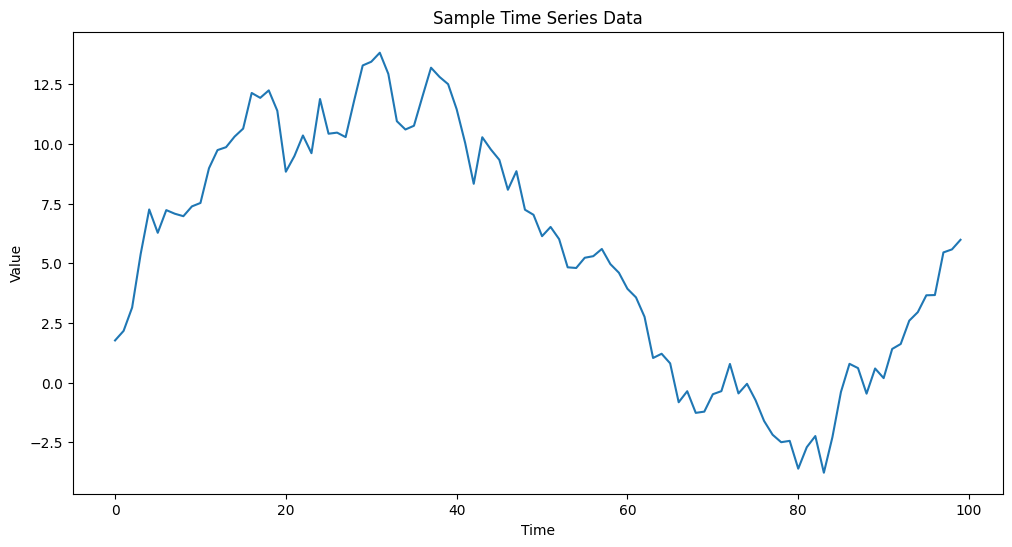

ADF Statistic: -1.1320384625097901
p-value: 0.7021277385898382
Critical Values:
1%: -3.498198082189098
5%: -2.891208211860468
10%: -2.5825959973472097


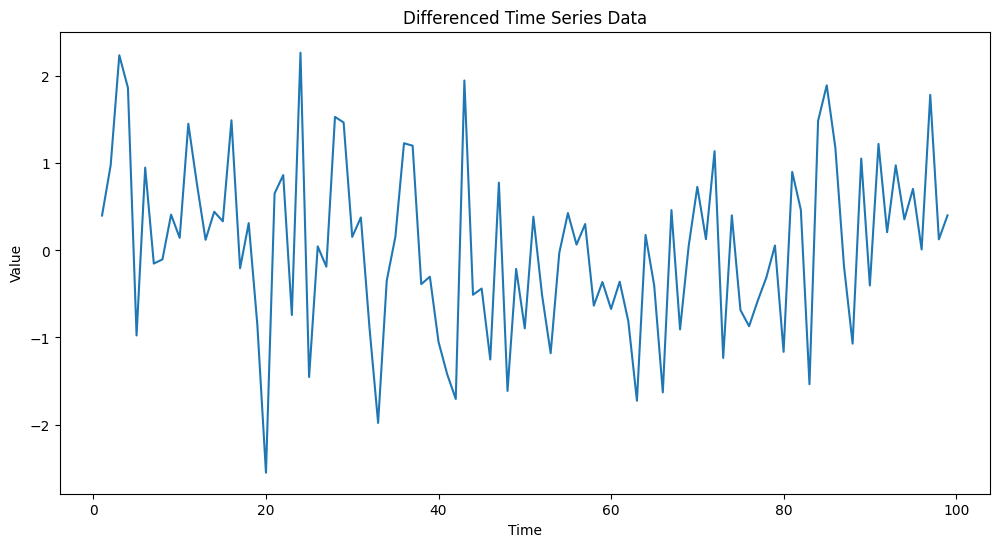

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -139.082
Date:                Tue, 12 Sep 2023   AIC                            284.163
Time:                        18:49:37   BIC                            291.949
Sample:                             0   HQIC                           287.313
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9450      0.082     11.491      0.000       0.784       1.106
ma.L1         -0.8819      0.115     -7.687      0.000      -1.107      -0.657
sigma2         0.9707      0.147      6.591      0.0

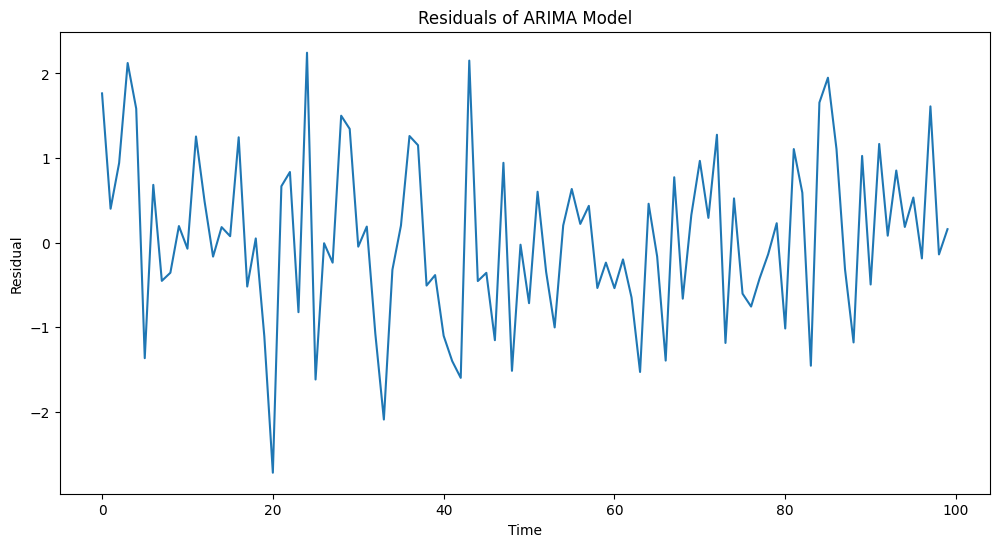

ValueError: ignored

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Generate a sample time series dataset
np.random.seed(0)
data = np.cumsum(np.random.randn(100))  # Random walk example
ts = pd.Series(data)

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Sample Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Check for stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

# If the series is not stationary, take the first difference to make it stationary
ts_diff = ts.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(ts_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Fit an ARIMA model
p = 1  # Autoregressive order
d = 1  # Integration order (differencing)
q = 1  # Moving Average order

model = sm.tsa.ARIMA(ts, order=(p, d, q))
results = model.fit()

# Summary of the ARIMA model
print(results.summary())

# Plot the residuals
residuals = pd.Series(results.resid)
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.show()

# Make forecasts
forecast_steps = 10
forecast, stderr, conf_int = results.forecast(steps=forecast_steps)

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(range(len(ts), len(ts) + forecast_steps), forecast, label='Forecast', color='red')
plt.fill_between(range(len(ts), len(ts) + forecast_steps), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
!pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download("AAPL", start="2006-01-01", end="2023-09-10")
stock_data

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('AAPL closing price')
plt.show()

In [ ]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit()
print(fitted.summary())

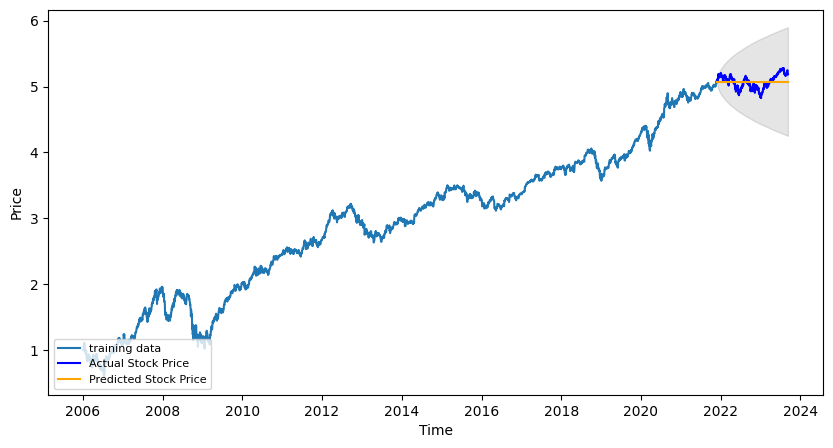

In [97]:
forecast_results = fitted.get_forecast(steps=446, alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(test_data.index, fc, color = 'orange',label='Predicted Stock Price')
plt.fill_between(test_data.index, conf.iloc[:, 0], conf.iloc[:, 1],
                 color='k', alpha=.10)

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left', fontsize=8)
plt.show()

In [101]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.010629261275016155
MAE: 0.08719955573687554
RMSE: 0.10309830878834121
MAPE: 0.017213829203243592
